# [House Prices Predict](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

#### 資料分析的第一步：EDA(exploratory data analysis)

* 預測目的: 問題是屬於 $Regression$ 問題還是 $classification$ 問題，預測房價為多少即是一個 $Regression$ 問題
* 了解問題: 觀察每個特徵的意義，以初步的假設思考是否有助於預測
* 對資料先進行簡單的初步整理
* 建立思考方向: 
    * 從預測值下手: 當房價變化時，哪些特徵有明顯的變化?  (正相關, 負相關, 無相關, 離群值)
    * 從特徵下手: 當某一個特徵變化時，哪些特徵亦有明顯的變化?  (ECDF(empirical distribution function))
* 清楚方向之後，針對特徵進行更進一步的篩選或是處理(例如: 排除無助於預測的特徵、離群值, 轉換類別數據, 特徵轉換)

#### 資料分析的第二步：建立預測模型

* 選擇適當的迴歸模型: 
    * `Linear regression`: 最基礎的迴歸模型，若表現不錯，適合作為一個 $base line$。
    * `Stepwise regression`: 逐步迴歸，遍歷所有特徵。
    * `Ridge regression`: 在`Linear regression`的損失函數上添加`L2`正則項，限制模型複雜度，賦予影響較大的特徵較高的權重係數，針對影響較小的特徵係數`收縮接近0`。
    * `Lasso regression`: 在`Linear regression`的損失函數上添加`L1`正則項，限制模型複雜度，將影響較少的特徵係數`收縮至0`，捨棄影響較少的特徵，進而達到特徵選擇的目的。
    * `Elastic Net Regression`: 在`Linear regression`的損失函數上同時加上`L1`與`L2`，目的同樣是限制模型複雜度。
    * `SVM Regression`: 效率快速且適合作為 $base line$ 的 `linear svm`，以及其他的非線性`kernel`也是不錯的選擇。
    
####  資料分析第三部：模型評估

* 針對迴歸問題，經常使用的評價指標有
    * 平均方差 $mse$ `(mean_squared_error)`
    * 平均絕對誤差 $mae$ `(mean_absolute_error)`
    * 判定係數 $R^2$ `(R-squared)`

### Data overview

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

UsageError: Line magic function `%` not found.


#### 房價資料包含了80個特徵，訓練資料數量為1460筆，測試資料則為1459筆

#### 這裏將訓練資料與測試資料合併在一起的原因是為了同時觀察全部資料的缺失值、欄位評級。

In [2]:
train = pd.read_csv('all/train.csv',index_col=False)
test = pd.read_csv('all/test.csv')
print('train.shape: ',train.shape)
print('test.shape: ',test.shape)
print(train.columns)
alldata = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                     test.loc[:,'MSSubClass':'SaleCondition']))
alldata = alldata.reset_index(drop=True)

train.shape:  (1460, 81)
test.shape:  (1459, 80)
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea

### 統計整筆alldata的缺失值。

In [3]:
misscol = []
for col in alldata.columns:
    if alldata[col].isnull().sum()>0:
        misscol.append(col)
        print(col,":" ,alldata[col].isnull().sum())

MSZoning : 4
LotFrontage : 486
Alley : 2721
Utilities : 2
Exterior1st : 1
Exterior2nd : 1
MasVnrType : 24
MasVnrArea : 23
BsmtQual : 81
BsmtCond : 82
BsmtExposure : 82
BsmtFinType1 : 79
BsmtFinSF1 : 1
BsmtFinType2 : 80
BsmtFinSF2 : 1
BsmtUnfSF : 1
TotalBsmtSF : 1
Electrical : 1
BsmtFullBath : 2
BsmtHalfBath : 2
KitchenQual : 1
Functional : 2
FireplaceQu : 1420
GarageType : 157
GarageYrBlt : 159
GarageFinish : 159
GarageCars : 1
GarageArea : 1
GarageQual : 159
GarageCond : 159
PoolQC : 2909
Fence : 2348
MiscFeature : 2814
SaleType : 1


### 討論有缺失值的欄位：
---

* `LotFrontage`：土地面向街道的寬度，缺失值補0

![](Lot_map.png)

* `Alley`：巷弄街道類型，Grvl為碎石路面，Pave為石塊路面，其中`NaN`有1369筆 ，數量過多，使用`missing`來代替

---

* `MasVnrType`：砌體結構類型，其中`None`有864筆，`NaN`有8筆，`NaN`以`None`來代替

* `MasVnrArea`：砌體面積，其中有861筆為0，`NaN`有8筆，`NaN`補`0`

---

* `BsmtQual`：地下室的高度，使用`TA,Gd,Ex,Fa`來表示高低程度，`NaN`有37筆，使用數量最多的`TA`代替

* `BsmtCond`：地下室的一般狀況，使用`TA,Gd,Fa,Po`來表示程度，`NaN`有37筆，使用數量最多的`TA`代替

* `BsmtExposure`：地下室牆壁，使用`No,Av,Gd,Mn`來表示，其中`NaN`有38筆，使用數量最多的`No`代替

* `BsmtFinType1`：地下室完工面積的品質，以`Unf,GLQ,ALQ,BLQ,Rec,LwQ`表示，`Nan`有37筆，使用數量最多的`Unf`來代替

* `BsmtFinType2`：地下室第二區域完成面積品質，類別表示同上，欄位說明中最後表示(if present)，`NaN`有38筆，使用數量最多的`Unf`來代替

---

* `Electrical`：供電系統，以`SBrkr,FuseA,FuseF,FuseP,Mix`表示，`NaN`只有1筆，使用數量最多的`SBrkr`代替

* `FireplaceQu`：壁爐品質，以`Gd,TA,Fa,Ex,Po`表示，`Nan`數量最多共有690筆，使用`missing`代替

---

* `GarageType`：車庫位置，`NaN`共有81筆，使用數量最多的`Attchd`代替

* `GarageYrBlt`：建立車庫的年份，`NaN`數量最多有81筆，其餘年份零零散散，從1933年至2005年數量呈現遞增，考慮不使用這個欄位

* `GarageFinish`：車庫完工程度，以`Unf,RFn,Fin`表示，`NaN`共有81筆，使用數量最多`Unf`來代替

* `GarageQual`：車庫品質，以`TA,Fa,Gd,Po,Ex`表示，`NaN`有81筆，使用數量最多`TA`來代替

* `GarageCond`: 車庫條件，以`TA,Fa,Gd,Po,Ex`表示，`NaN`有81筆，使用數量最多`TA`代替

---

* `PoolQC`：游泳池品質，以`Gd,Ex,Fa`表示，`NaN`數量最多，共有1453筆，使用`missing`代替

* `Fence`：柵欄品質，以`MnPrv,GdPrv,GdWo,MnWw`表示，`NaN`數量最多，共有1179筆，使用`missing`代替

* `MiscFeature`：其餘的冗余特徵，以`Shed,Gar2,Othr,TenC`表示，`NaN`數量最多，有1406筆，使用`missing`代替

---

以上是針對欄位缺失值的處理，其中有些欄位的缺失值數量是相近或是一模一樣的，例如`Bsmt`開頭的欄位，數量皆在37~38筆，檢查會發現其實這五個欄位其實是同一筆資料，針對同一筆資料會傾向於使用同一種處理缺失值的方式，例如將`NaN`使用數量最多的`TA`來代替。

另外，`Garage`開頭的欄位，數量全部都是81筆，檢查發現這81筆其實也是同一筆資料，傾向於使用同一種處理方式，例如將`NaN`使用數量最多的`Unf`來代替。

也許有人會思考說，如果含有`NaN`的欄位都是來自同一筆資料，那只要把那筆資料拿掉就好啦？我這裡選擇不拿掉的原因是因為訓練資料只有1460筆，因為資料量實在太少了，所以想盡量保留資料裡面的訊息。

### 檢查欄位各類別數量的方式，替換欄位部分即可

In [4]:
alldata['Exterior1st'].value_counts(dropna=False)

VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
CBlock        2
AsphShn       2
Stone         2
ImStucc       1
NaN           1
Name: Exterior1st, dtype: int64

### 檢查具有同樣名稱開頭欄位的`NaN`是否來是同一筆資料

In [5]:
alldata[alldata.GarageType.isnull()].loc[:,['GarageType','GarageYrBlt','GarageFinish','GarageQual']]

,GarageType,GarageYrBlt,GarageFinish,GarageQual
39,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN
88,NaN,NaN,NaN,NaN
89,NaN,NaN,NaN,NaN
...,...,...,...,...
2893,NaN,NaN,NaN,NaN
2909,NaN,NaN,NaN,NaN
2913,NaN,NaN,NaN,NaN
2914,NaN,NaN,NaN,NaN


### 定義處理缺失值函數

In [6]:
def fill_nan(data):
    data['LotFrontage'] = data['LotFrontage'].fillna(0)
    data['Alley'] = data['Alley'].fillna('missing')
    data['MasVnrType'] = data['MasVnrType'].fillna('None')
    data['MasVnrArea'] = data['MasVnrArea'].fillna(0)
    data['BsmtQual'] = data['BsmtQual'].fillna('TA')
    data['BsmtCond'] = data['BsmtCond'].fillna('TA')
    data['BsmtExposure'] = data['BsmtExposure'].fillna('No')
    data['BsmtFinType1'] = data['BsmtFinType1'].fillna('Unf')
    data['BsmtFinType2'] = data['BsmtFinType2'].fillna('Unf')
    data['Electrical'] = data['Electrical'].fillna('SBrkr')
    data['FireplaceQu'] = data['FireplaceQu'].fillna('missing')
    data['GarageType'] = data['GarageType'].fillna('Attchd')
    data = data.drop('GarageYrBlt', axis=1)
    data['GarageFinish'] = data['GarageFinish'].fillna('Unf')
    data['GarageQual'] = data['GarageQual'].fillna('TA')
    data['GarageCond'] = data['GarageCond'].fillna('TA')
    data['PoolQC'] = data['PoolQC'].fillna('missing')
    data['Fence'] = data['Fence'].fillna('missing')
    data['MiscFeature'] = data['MiscFeature'].fillna('missing')
    data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].mode()[0]) # 針對數量極少的NaN，直接使用眾數來代替
    data['Utilities'] = data['Utilities'].fillna(data['Utilities'].mode()[0])
    data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
    data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])
    data['BsmtFinSF1'] = data['BsmtFinSF1'].fillna(data['BsmtFinSF1'].mode()[0])
    data['BsmtFinSF2'] = data['BsmtFinSF2'].fillna(data['BsmtFinSF2'].mode()[0])
    data['BsmtUnfSF'] = data['BsmtUnfSF'].fillna(data['BsmtUnfSF'].mode()[0])
    data['TotalBsmtSF'] = data['TotalBsmtSF'].fillna(data['TotalBsmtSF'].mode()[0])
    data['BsmtFullBath'] = data['BsmtFullBath'].fillna(data['BsmtFullBath'].mode()[0])
    data['BsmtHalfBath'] = data['BsmtHalfBath'].fillna(data['BsmtHalfBath'].mode()[0])
    data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].mode()[0])
    data['Functional'] = data['Functional'].fillna(data['Functional'].mode()[0])
    data['GarageCars'] = data['GarageCars'].fillna(data['GarageCars'].mode()[0])
    data['GarageArea'] = data['GarageArea'].fillna(data['GarageArea'].mode()[0])
    data['SaleType'] = data['SaleType'].fillna(data['SaleType'].mode()[0])

    return data

In [7]:
alldata = fill_nan(alldata)
print('處理完後NaN數量:',alldata.isnull().any().sum())

處理完後NaN數量: 0


### 處理完`NaN`之後，我們來觀察欄位名稱是否有一些訊息

In [274]:
print(alldata.columns)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'Ope

### 有些欄位有一些規律，像是針對一個物件的條件、品質、質量、面積等等進行評價，而且透過上方處理`NaN`時發現，某些欄位評價的評級其實是相同的，例如說`GarageQual`以及`GarageCond`的評級都是`TA,Fa,Gd,Po,Ex`，現在我們來統計有同樣評級的欄位有哪些，還有可以用程度表示的欄位有哪些。

In [275]:
categorical = [col for col in alldata.columns if alldata[col].dtype == 'O']
for i in categorical:
    print(i,':',alldata[i].unique())

MSZoning : ['RL' 'RM' 'C (all)' 'FV' 'RH']
Street : ['Pave' 'Grvl']
Alley : ['missing' 'Grvl' 'Pave']
LotShape : ['Reg' 'IR1' 'IR2' 'IR3']
LandContour : ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities : ['AllPub' 'NoSeWa']
LotConfig : ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope : ['Gtl' 'Mod' 'Sev']
Neighborhood : ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1 : ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2 : ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
BldgType : ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle : ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle : ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl : ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTil

### 接下來花一點功夫整理，我們針對有意義的各個欄位的順序資料評級給予一個數值，可以透過這份[說明文件](https://ww2.amstat.org/publications/jse/v19n3/decock/datadocumentation.txt)作為依據

* `Street,Alley`：`['missing' 'Grvl' 'Pave']`

* `LandSlope`：`['Gtl' 'Mod' 'Sev']`

* `HouseStyle`：`['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']`

* `ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC`：`['EX' 'Gd' 'TA' 'Fa' 'Po' ]`

* `Foundation`：`['PConc' 'CBlock' 'BrkTil' 'Wood' 'Slab' 'Stone']`

* `BsmtExposure`：`['No' 'Gd' 'Mn' 'Av']`

* `BsmtFinType1,BsmtFinType2`：`['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'LwQ']`

* `CentralAir`：`['Y' 'N']`

* `Functional`：`['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev']`

* `GarageFinish`：`['RFn' 'Unf' 'Fin']`

* `PavedDrive`：`['Y' 'N' 'P']`

* `Fence`：`['missing' 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']`

---

* `MSSubClass`：`[ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75, 180,  40, 150]`

* `OverallQual`：`[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]`

* `OverallCond`：`[1, 2, 3, 4, 5, 6, 7, 8, 9]`

In [276]:
from sklearn.preprocessing import LabelEncoder
# 這裏有些使用map有些使用labelencoder的原因是因為將數值轉換為str後，順序會亂掉導致labelencoder轉換不正確
# 順序不正確的需要額外挑出來重新排序
alldata['MSSubClass'] = alldata['MSSubClass'].astype(str).map({'20':0,'30':1,'40':2,'45':3,'50':4,'60':5,'70':6,'75':7,'80':8,'85':9,'90':10,'120':11,'150':12,'160':13,'180':14,'190':15})
alldata['OverallQual'] = alldata['OverallQual'].astype(str).map({'1':0,'2':1,'3':2,'4':3,'5':4,'6':5,'7':6,'8':7,'9':8,'10':9})
alldata['MoSold'] = alldata['MoSold'].astype(str).map({'1':0,'2':1,'3':2,'4':3,'5':4,'6':5,'7':6,'8':7,'9':8,'10':9,'11':10,'12':11})
alldata['HouseStyle'] = alldata['HouseStyle'].map({'1Story':0,'1.5Unf':1,'1.5Fin':2,'2Story':3,'2.5Unf':4,'2.5Fin':5,'SFoyer':6,'SLvl':7})

qual_dict = {'missing':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
alldata['ExterQual'] = alldata['ExterQual'].map(qual_dict)
alldata['ExterCond'] = alldata['ExterCond'].map(qual_dict)
alldata['BsmtQual'] = alldata['BsmtQual'].map(qual_dict)
alldata['BsmtCond'] = alldata['BsmtCond'].map(qual_dict)
alldata['HeatingQC'] = alldata['HeatingQC'].map(qual_dict)
alldata['KitchenQual'] = alldata['KitchenQual'].map(qual_dict)
alldata['FireplaceQu'] = alldata['FireplaceQu'].map(qual_dict)
alldata['GarageQual'] = alldata['GarageQual'].map(qual_dict)
alldata['GarageCond'] = alldata['GarageCond'].map(qual_dict)
alldata['PoolQC'] = alldata['PoolQC'].map(qual_dict)

alldata['BsmtExposure'] = alldata['BsmtExposure'].map({'No':0,'Mn':1,'Av':2,'Gd':3})
alldata['BsmtFinType1'] = alldata['BsmtFinType1'].map({'Unf':0,'LwQ':1,'Rec':2,'BLQ':3,'ALQ':4,'GLQ':5})
alldata['BsmtFinType2'] = alldata['BsmtFinType2'].map({'Unf':0,'LwQ':1,'Rec':2,'BLQ':3,'ALQ':4,'GLQ':5})
alldata['Functional'] = alldata['Functional'].map({'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7})
alldata['GarageFinish'] = alldata['GarageFinish'].map({'Unf':0,'RFn':1,'Fin':2})
alldata['Fence'] = alldata['Fence'].map({'missing':0,'MnWw':1,'GdWo':2,'MnPrv':3,'GdPrv':4})


alldata['OverallCond'] = alldata['OverallCond'].astype(str)
alldata['YearRemodAdd'] = alldata['YearRemodAdd'].astype(str)
cols = ['Street','Alley','LandSlope','Foundation','CentralAir','PavedDrive','OverallCond','YearRemodAdd']

for col in cols:
    lbender = LabelEncoder() 
    lbender.fit(list(alldata[col].values)) 
    alldata[col] = lbender.transform(list(alldata[col].values))

### 從數值型的欄位觀察，是否有我們認為不需要的欄位或是能夠互相interate的欄位。

* `YearBuilt`：建築施工日期。
* `YearRemodAdd`：建築整修日期，如果沒有整修就與`YearBuilt`一樣。
* `BsmtFinType1,BsmtFinType2`：皆為地下室竣工面積品質。
* `BsmtFinSF1,BsmtFinSF2`：皆為地下室竣工面積。
* `TotalBsmtSF,1stFlrSF,2ndFlrSF`：地下室總面積、一樓及二樓面積。
* `BsmtFullBath,BsmtHalfBath,FullBath,HalfBath`：地下室浴室數量,地面以上的浴室數量。
* `OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch`：皆是走廊的面積。
* `YrSold`：銷售年份，可以與上面的`YearBuilt`結合，得到房屋銷售時的屋齡。

In [277]:
def numerical_proc(data):
    data['BsmtFinType'] = data['BsmtFinType1'] + data['BsmtFinType2']
    data['BsmtFinSF'] = data['BsmtFinSF1'] + data['BsmtFinSF2']
    data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
    data['Bath'] = data['BsmtFullBath'] + data['BsmtHalfBath'] + data['FullBath'] + data['HalfBath']
    data['Porch'] = data['OpenPorchSF'] + data['EnclosedPorch'] + data['3SsnPorch'] + data['ScreenPorch']
    data['BuildingAge'] = data['YrSold'] - data['YearBuilt']
    return data

alldata = numerical_proc(alldata)

### 得到屋齡後，將`YrSold`及`YearBuilt`轉成`label encoder`

In [278]:
alldata['YrSold'] = alldata['YrSold'].astype(str)
alldata['YearBuilt'] = alldata['YearBuilt'].astype(str)
cols = ['YrSold','YearBuilt']
for col in cols:
    lbender = LabelEncoder() 
    lbender.fit(list(alldata[col].values)) 
    alldata[col] = lbender.transform(list(alldata[col].values))

### 現在我們大致完成了所有欄位的處理，接下來從訓練資料中的房價作為解釋變數下手，觀察每個特徵對房價的相關性，將分成連續型與離散型。

* 連續型數值：例如`GarageArea`車庫面積就是個連續型數值，我們期望看到當面積越大，房價也越高的情況。

* 離散型數值：例如`OverallQual`房屋材料與質量是以等級來區分，總共1~10級，我們期望看到當數值等級越高時，房價也越高的情況

---

### 針對連續型變數，適合使用散佈圖來觀察趨勢

從中發現，大部分的散佈圖當 $x$ 軸數值越來越大時，房價的確是越來越高，但是離群值也越來越多，當遇到這種情況時，我們考慮去除離群值以及使用對數轉換，減少離群值對整體資料的影響。

這裏需要另外注意，屋齡`BuildingAge`是負相關，這是因為屋齡越老房價越便宜，負相關對於迴歸預測也是有幫助的，這個欄位需要保留。

In [279]:
continuous = ['LotFrontage','LotArea','MasVnrArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','BsmtFinSF1','ScreenPorch','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','BsmtFinSF','2ndFlrSF','TotalSF','LowQualFinSF','GrLivArea','Porch','BuildingAge']

In [280]:
plotdd = alldata[:train.shape[0]]
plotdd['SalePrice'] = train.SalePrice

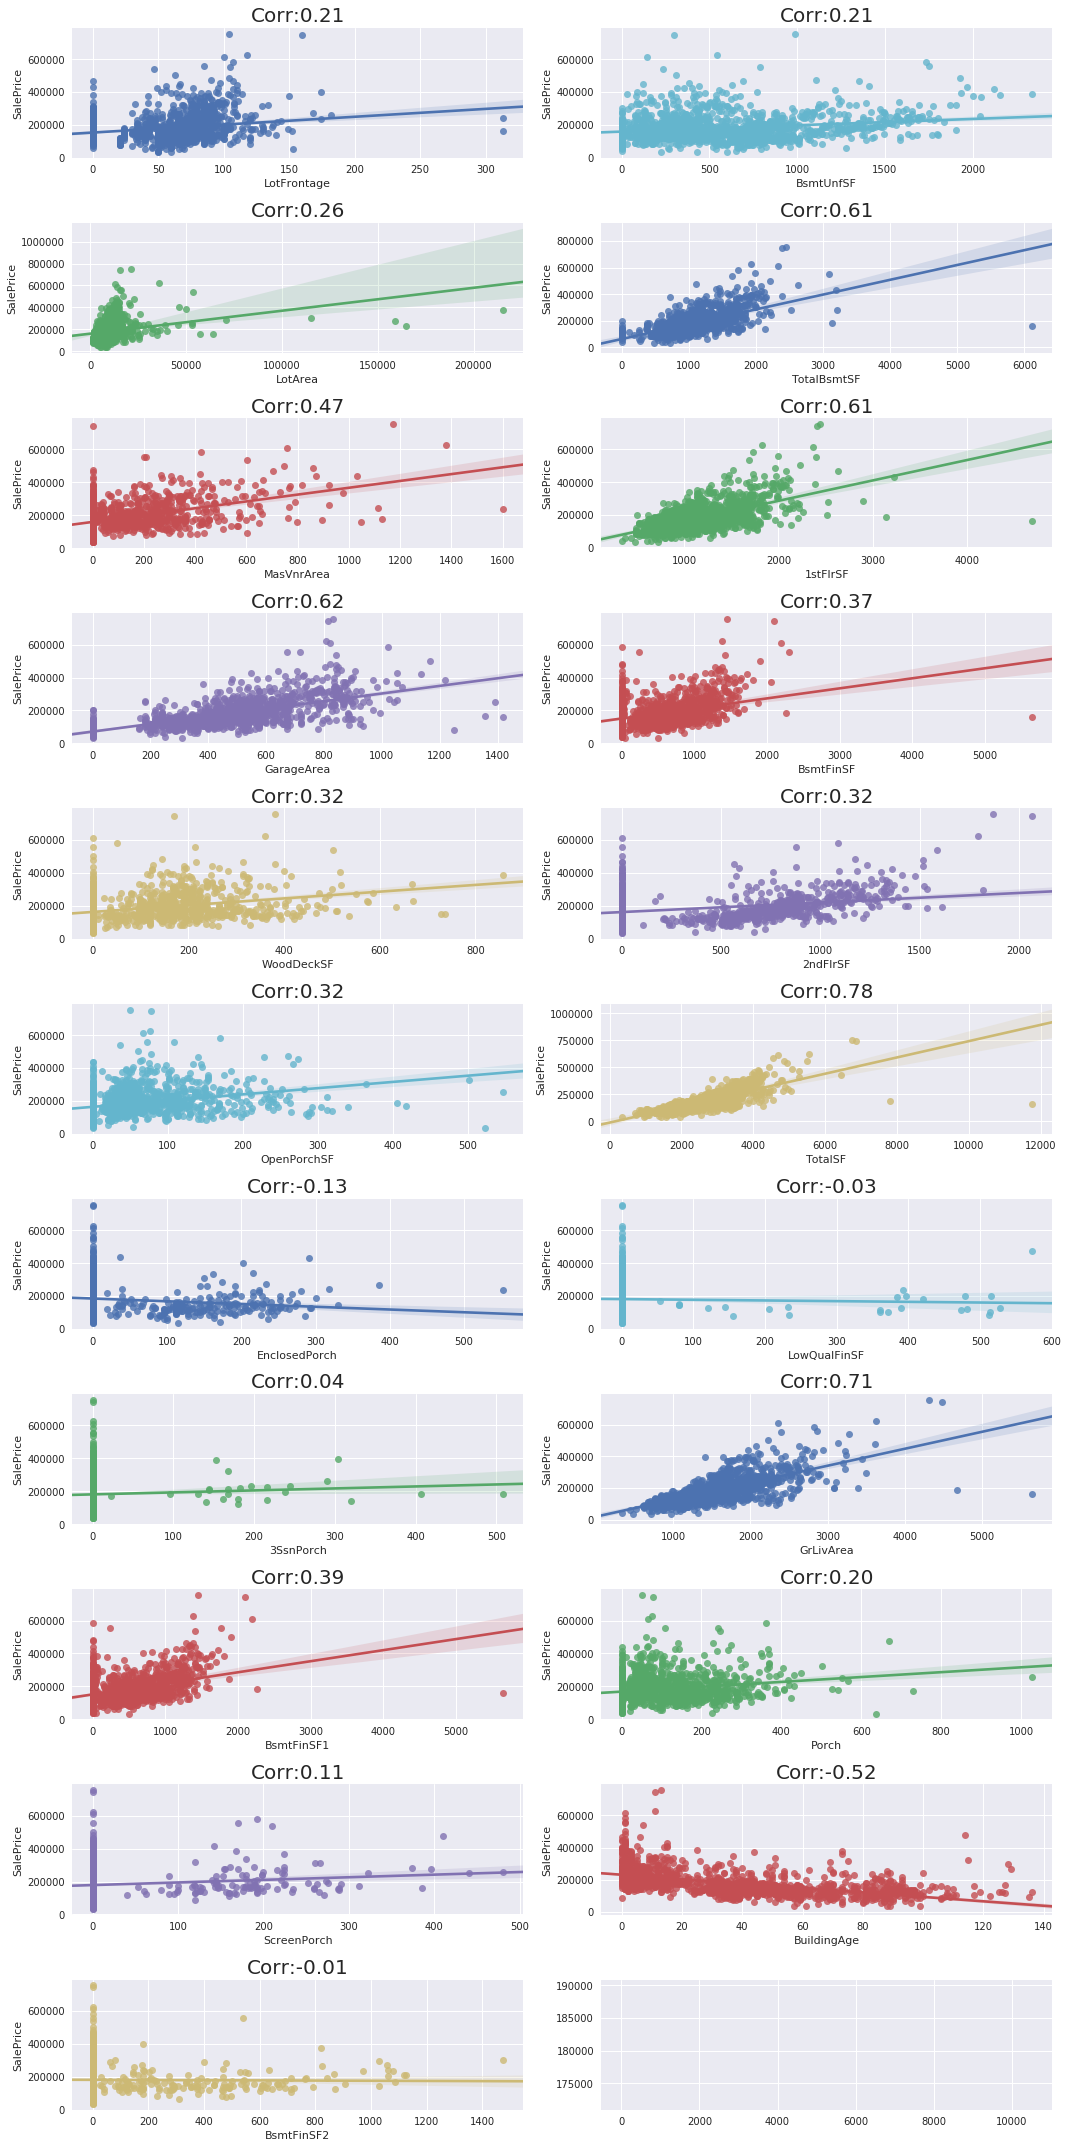

In [281]:
rcParams['figure.figsize'] = (15,30)
fig, axes = plt.subplots(11,2)
sns.set()
for i in range(len(continuous)):
    if i < 11:
        pp = sns.regplot(data=plotdd, x=continuous[i], y='SalePrice', ax=axes[i,0])
        pp.set_title('Corr:%.2f' % np.corrcoef(plotdd['SalePrice'],plotdd[continuous[i]])[0,1],size=20)
    else:
        pp2 = sns.regplot(data=plotdd, x=continuous[i], y='SalePrice', ax=axes[i-11,1])
        pp2.set_title('Corr:%.2f' % np.corrcoef(plotdd['SalePrice'],plotdd[continuous[i]])[0,1],size=20)
    plt.tight_layout()

### 接下來，決定把離群值剔除。

In [282]:
#alldata = alldata.drop(plotdd[(plotdd['TotalBsmtSF']>5000) & (plotdd['SalePrice']<300000)].index)
#alldata = alldata.drop(plotdd[(plotdd['1stFlrSF']>4000) & (plotdd['SalePrice']<300000)].index)
#alldata = alldata.drop(plotdd[(plotdd['BsmtFinSF']>5000) & (plotdd['SalePrice']<300000)].index)
#alldata = alldata.drop(plotdd[(plotdd['TotalSF']>10000) & (plotdd['SalePrice']<300000)].index)
# 這裏發現離群值其實都是同一筆，而GrLivArea的離群值多一筆
alldata = alldata.drop(plotdd[(plotdd['GrLivArea']>4000) & (plotdd['SalePrice']<300000)].index)
y = train['SalePrice'].drop(plotdd[(plotdd['GrLivArea']>4000) & (plotdd['SalePrice']<300000)].index)

plotdd = plotdd.drop(plotdd[(plotdd['GrLivArea']>4000) & (plotdd['SalePrice']<300000)].index)
#alldata = alldata.drop(plotdd[(plotdd['BsmtFinSF1']>5000) & (plotdd['SalePrice']<300000)].index)

### 針對離散型變數，適合使用盒鬚圖

前面我們已經針對評級進行數值轉換，所以現在的`x軸`由左至右是具有大小優劣程度之分，例如`OverallQual`隨著評分越高，房價是跟著上升的，所以我們可以透過這樣的方式，來判斷哪些欄位是我們感興趣的。


* `PavedDrive,Functional,CentralAir,BsmtExposure,Alley,GarageFinish,
BsmtFinType2,FullBath,OverallCond,BsmtCond,BsmtFinType,Fireplaces,YearBuilt`

以上欄位是透過以下盒鬚圖篩選而來的，其中，`LandSlope`表示房屋位置的土地坡度傾斜程度，盒鬚圖表示當坡度越平緩，房價會越便宜，雖然這違反直覺，但是我相信這是有可能的，因為波士頓地理位置靠海，地形起伏不大，而坡度傾斜程度高的地方可能是山丘、高地，數量相對稀少，物以稀為貴，能夠有一個地方可以眺望大海是非常稀少的，所以我認為資料這樣表示是合理的。

In [283]:
discrete1 = ['LandSlope','YearBuilt','PavedDrive','Functional','CentralAir','BsmtExposure','Alley','GarageFinish','BsmtFinType2','FullBath','OverallCond','BsmtCond','BsmtFinType','Fireplaces']

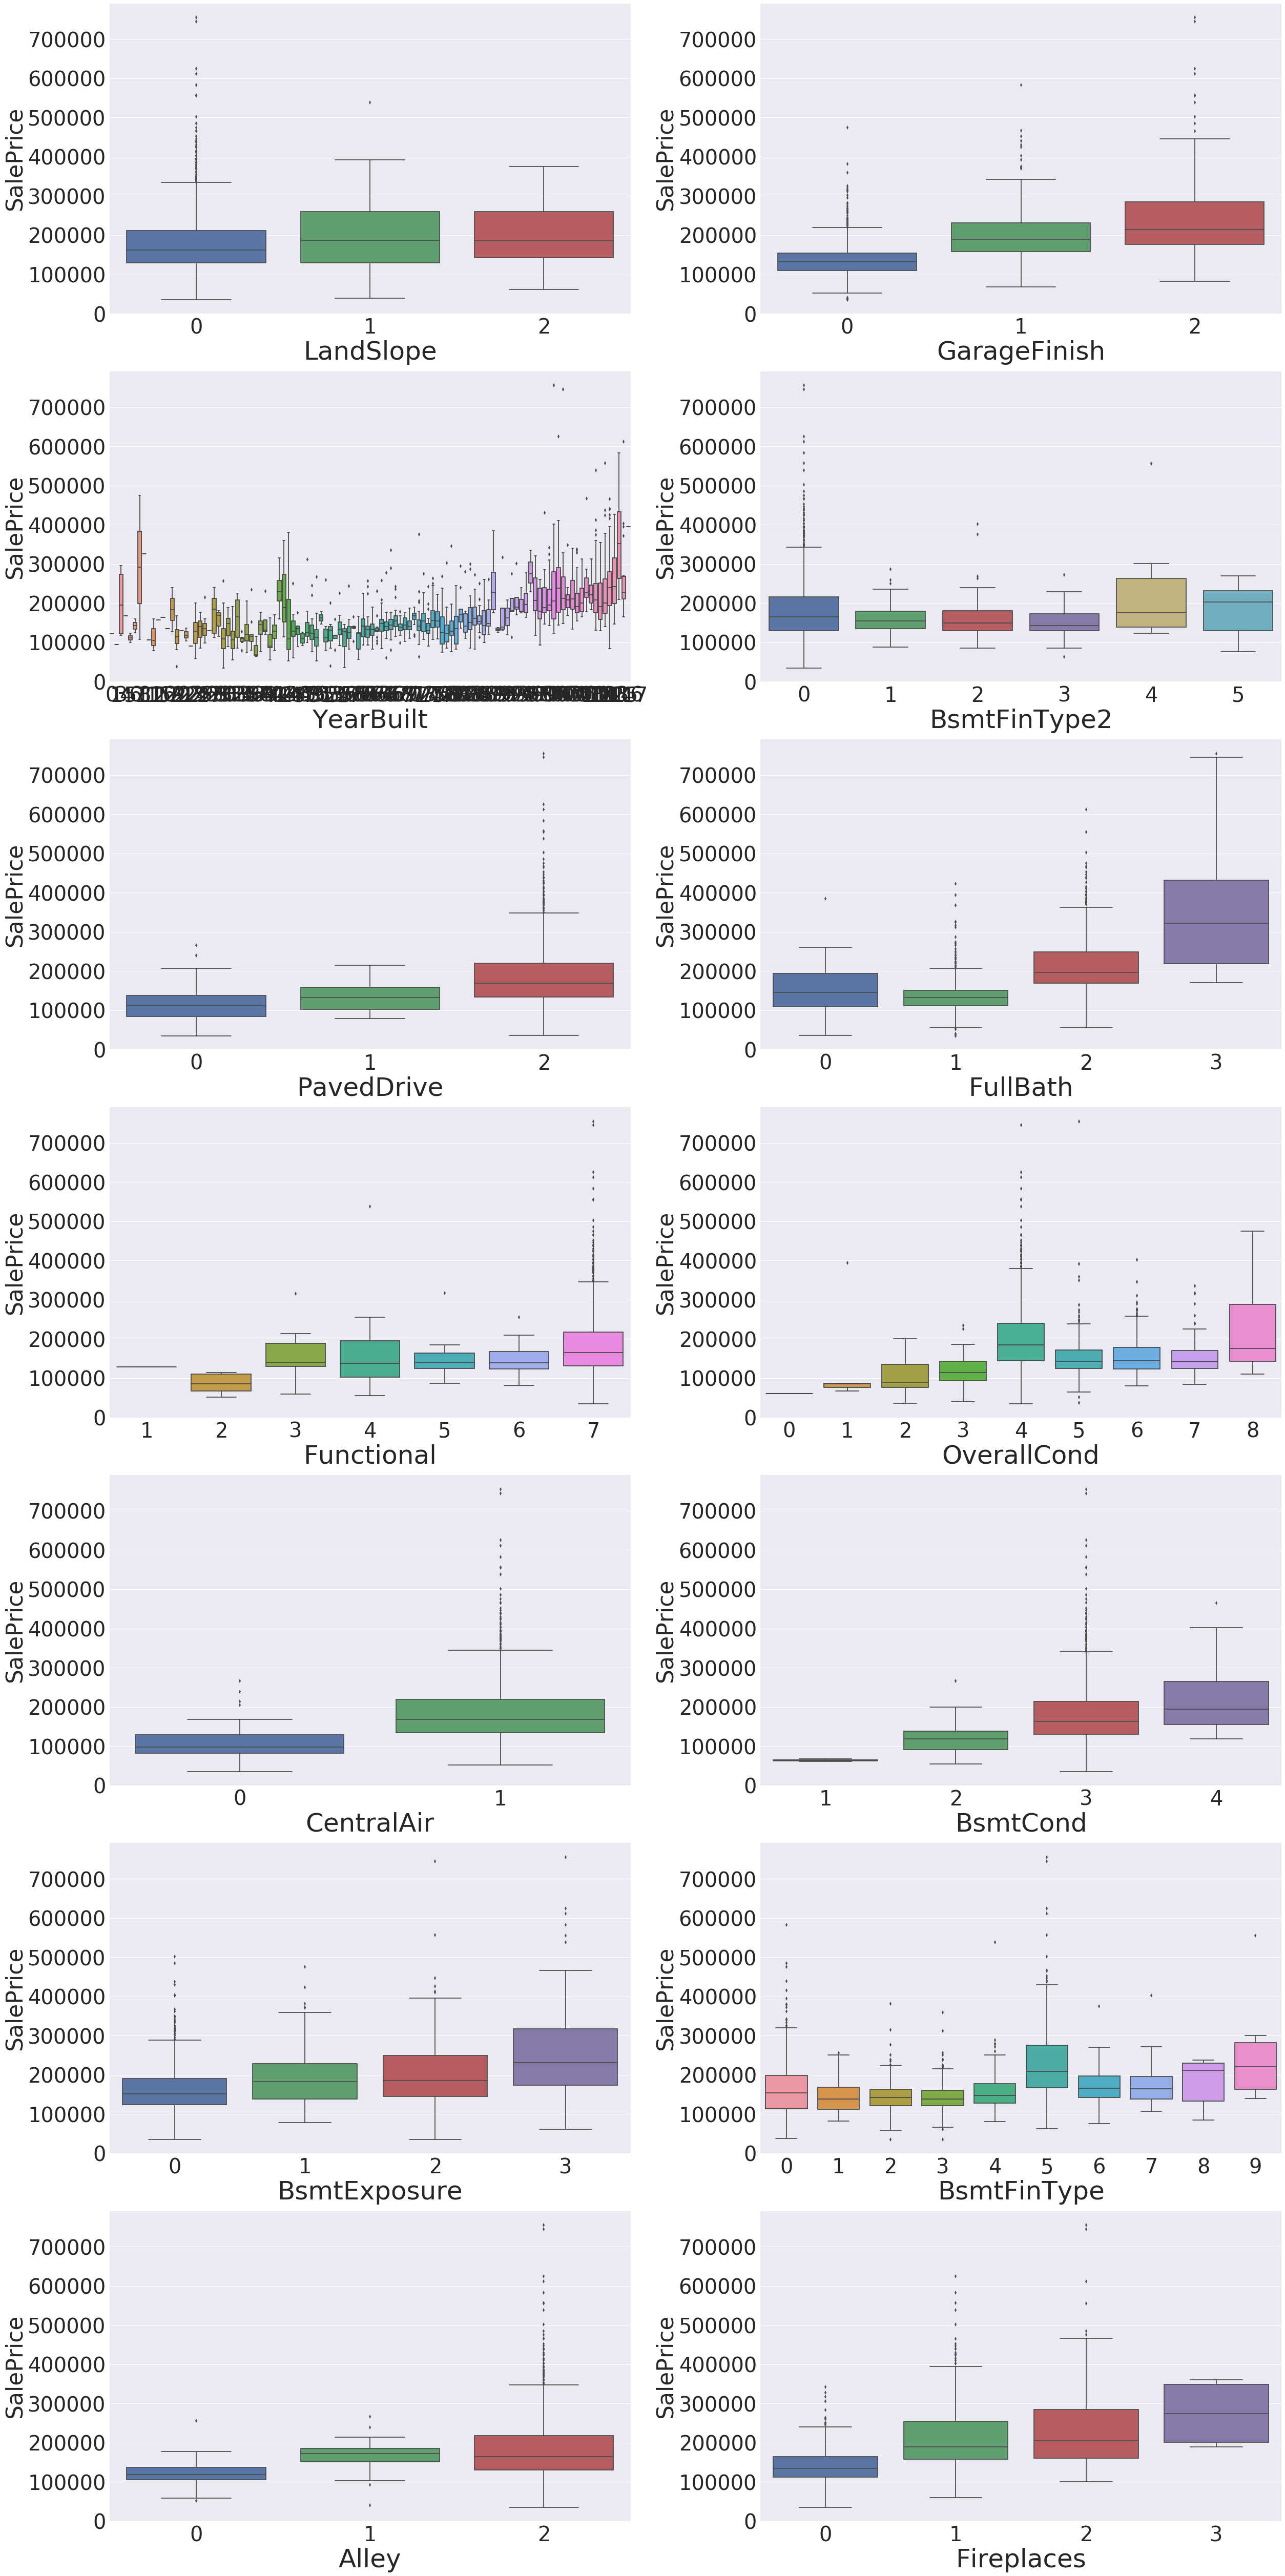

In [284]:
sns.set(font_scale=4)
rcParams['figure.figsize'] = (35,70)
fig, axes = plt.subplots(7,2)
sns.set(color_codes=True)
for i in range(len(discrete1)):
    if i < 7:
        pp = sns.boxplot(data=plotdd, x=discrete1[i], y='SalePrice', ax=axes[i,0])
        pp.set_xlabel(discrete1[i],fontsize=50)
    else:
        pp2 = sns.boxplot(data=plotdd, x=discrete1[i], y='SalePrice', ax=axes[i-7,1])
        pp2.set_xlabel(discrete1[i],fontsize=50)
    plt.tight_layout()

#### 接下來討論其餘欄位

`Street,GarageCond,BsmtFinType1,GarageCars,ExterQual,TotRmsAbvGrd,OverallQual,BsmtQual`
`KitchenQual,Bath,FireplaceQu,GarageQual,BsmtFullBath,HeatingQC`

以上欄位是我覺得當評價變動時，房價確實有上升的欄位，其中像是`GarageCond`,`BsmtFinType1,GarageCars,Bath`上升到一定程度後房價就持平的欄位，我想可能是某些買家對於這些欄位到達一定程度後對於價格的敏感程度就飽和了，也就是再多我也沒興趣的意思。

In [285]:
discrete2 = ['Street','GarageCond','BsmtFinType1','GarageCars','ExterQual','TotRmsAbvGrd','OverallQual','BsmtQual','KitchenQual','Bath','FireplaceQu','GarageQual','BsmtFullBath','HeatingQC']

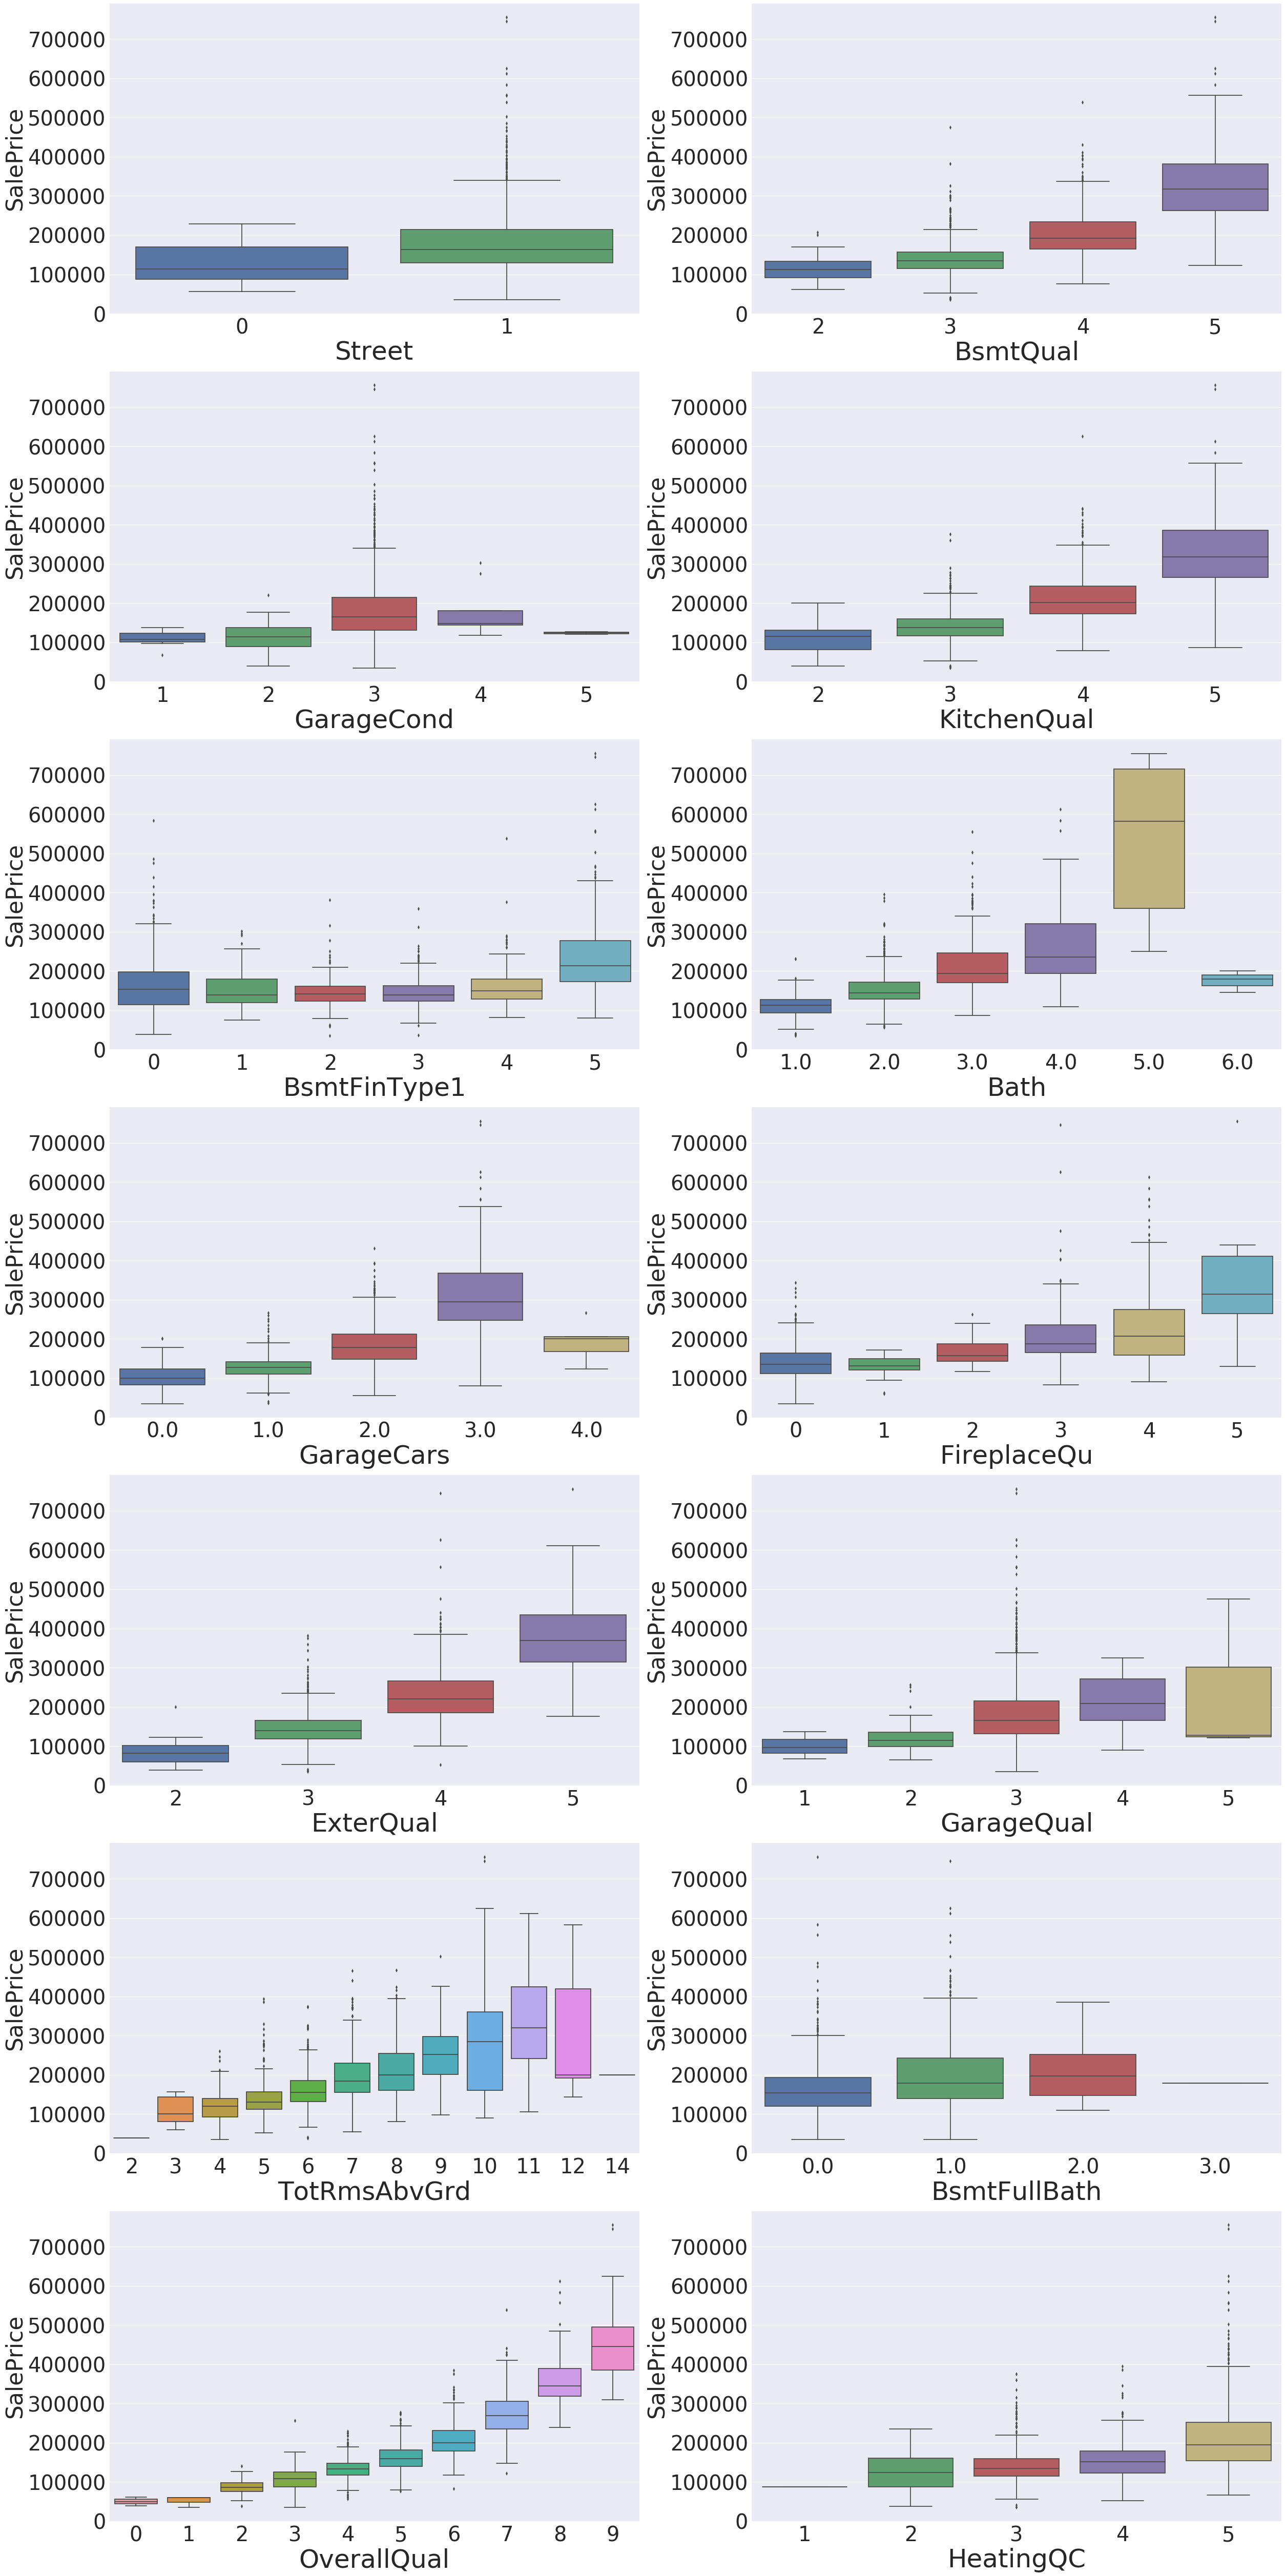

In [286]:
sns.set(font_scale=4)
rcParams['figure.figsize'] = (35,70)
fig, axes = plt.subplots(7,2)
sns.set(color_codes=True)
for i in range(len(discrete2)):
    if i < 7:
        pp = sns.boxplot(data=plotdd, x=discrete2[i], y='SalePrice', ax=axes[i,0])
        pp.set_xlabel(discrete2[i],fontsize=50)
    else:
        pp2 = sns.boxplot(data=plotdd, x=discrete2[i], y='SalePrice', ax=axes[i-7,1])
        pp2.set_xlabel(discrete2[i],fontsize=50)
    plt.tight_layout()

In [287]:
# unuse = ['BsmtHalfBath','GarageQual','KitchenAbvGr','HalfBath','Exterior2nd','BsmtFinType1','Condition1','MSZoning',
#          'Neighborhood','RoofMatl','Fence','Exterior1st','YrSold','Utilities','Heating','YearBuilt','MSSubClass','Condition2',
#          'PoolArea','BldgType','ExterCond','PoolQC','YearRemodAdd','MiscVal','MoSold','BsmtFinType']
# alldata = alldata.drop(unuse, axis=1)

## 接下來，我們要對數值做對數轉換

### 為何要進行對數轉換？

對數轉換的目的是為了減少數值差距過大及離群值而帶來的影響，從`絕對差異`轉變為`相對差異`，使得因變量的方差(離散程度)穩定。

1. 其中一個原因是為了閱讀上的方便，社會統計數據例如`家庭平均年收`,`國民人均所得`等等，通常都是屬於`右偏分佈`的資料，因為有錢人屬於少數，肯定會把整體的平均拉高，而且動輒幾億的身價會將`x軸`拉得非常非常的長，取對數之後，這種幾億的`絕對差異`，就會變成級距的`相對差異`，例如將 $10^9$取$\log_{10}$就是$9$，差距瞬間就減少，但是要注意的是，取對數後的資料單位就不具意義了。

2. 還有一個原因是配合統計需求，下圖是`GrLiveArea`與`SalePrice`散佈圖與密度圖，從左圖看來兩者有呈現一點指數遞增的關係，`相關係數`為$0.73$，兩者的資料分佈皆呈現`右偏分佈`，而迴歸模型的基本假設是資料為`線性關係`，顯然這種分佈不適合迴歸模型，所以這裏就需要用到`對數轉換`，右圖是經過`對數轉換`的結果，我們發現經過`對數轉換`後，`相關係數`有提升，而且從`非線性`轉為`線性`。

### 對數轉換實例 (非線性$\rightarrow$線性)

$$
\begin{aligned}
&Nonlinear: y = ab^x \\
Linear:\;&\log y = \log a + x\log b
\end{aligned}
$$

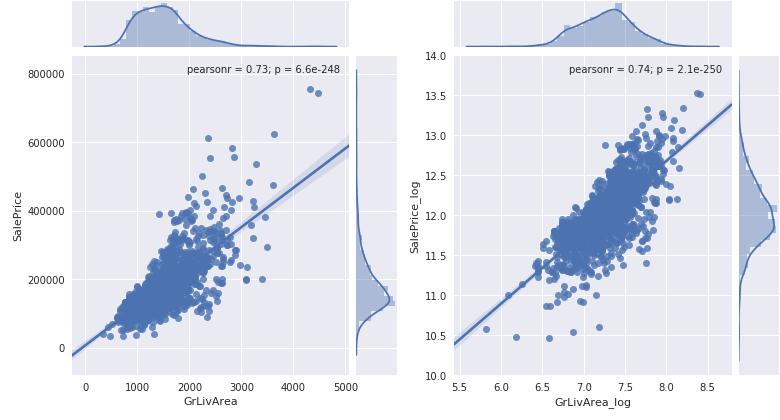

In [288]:
from scipy.stats import zscore
example = plotdd.copy()
example['SalePrice_log'] = np.log1p(example['SalePrice'])
example['GrLivArea_log'] = np.log1p(example['GrLivArea'])

sns.set()
import matplotlib.gridspec as gridspec
import SeabornFig2Grid as sfg
pp = sns.jointplot(x='GrLivArea',y='SalePrice',data=example,kind='reg')
pp2 = sns.jointplot(x='GrLivArea_log',y='SalePrice_log',data=example,kind='reg')

fig = plt.figure(figsize=(11,6))
gs = gridspec.GridSpec(1,2)

sfg.SeabornFig2Grid(pp, fig, gs[0])
sfg.SeabornFig2Grid(pp2, fig, gs[1])
plt.tight_layout()
plt.show()

#### 接下來，我們透過`偏態係數`，來檢驗資料分佈是否屬於`偏態分佈`，此指標能夠確認資料分佈是否對稱。
$$
SK = \frac{3(\bar{X}-X_{med})}{\sigma}
$$
其中，$\bar{X}$為平均數，$X_med$為中位數，$\sigma$為標準差。

$SK>0$表示右偏(正偏)，$SK<0$表示左偏(負偏)。

In [289]:
numerical_alldata = [col for col in alldata.columns if alldata[col].dtype != 'O']

In [290]:
from scipy.stats import skew
skew_indx = alldata.skew(axis=0).sort_values(ascending=False)
print(skew_indx.head(10))

MiscVal          21.950962
PoolQC           19.558938
PoolArea         17.697766
LotArea          13.116240
LowQualFinSF     12.090757
3SsnPorch        11.377932
LandSlope         4.975813
KitchenAbvGr      4.302763
BsmtFinSF2        4.146636
EnclosedPorch     4.004404
dtype: float64


偏態係數沒有一個絕對範圍，大於`0.5`時我們就可以稱分佈過於`右偏`，反之，小於`-0.5`就是`左偏`。

In [291]:
skew_indx = skew_indx[abs(skew_indx) > 0.75]
skew_indx = skew_indx.index
alldata[skew_indx] = np.log1p(alldata[skew_indx])

### 剩下欄位屬於名目資料，使用`One-hot encoding`表示

In [292]:
alldata = pd.get_dummies(alldata)

####  因為在train data上去除了2個離群值，所以剩餘1458筆

In [293]:
X_train = alldata[:1458]
X_test = alldata[1458:]
y_train = y
y_train = np.log1p(y_train) # 將預測值SalePrice取對數，讓特徵與預測值相關性提高

In [294]:
print('X_train.shape: ',X_train.shape)
print('X_test.shape: ',X_test.shape)
print('y_train.shape: ',y_train.shape)

X_train.shape:  (1458, 216)
X_test.shape:  (1459, 216)
y_train.shape:  (1458,)


## Summary

我們總結一下目前為止的步驟

   1. 在一開始資料探索，我們檢查了所有資料的缺失值 `NaN`，並透過[說明文件](https://ww2.amstat.org/publications/jse/v19n3/decock/datadocumentation.txt)來處理替換。
   2. 檢查所有欄位評級，在評價上有優劣關係的欄位，使用`LabelEncoder`轉成數值型態。
   3. 接下來，有些欄位可以互相結合成為一個新的特徵。
   4. 針對連續型態及離散型態的欄位畫圖，去除離群值。
   5. 為了符合迴歸基本`線性關係`假設，我們針對`偏態係數`大於0.75的欄位以及`SalePrice`進行對數轉換。
   6. 其餘沒有優劣關係的名目資料的欄位，我們將其使用`One-hot encoding`來轉換。
   
接下來，我們使用對數轉換過的預測值`SalePrice`訓練得到模型之後，最後在`testing data`上得到的最終預測值需要使用自然指數 $e$ 轉換回去。